In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
import os, sys
sys.path.append('../functions')

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Read Data

In [4]:
data = pandas.read_csv('Data/hits.csv', index_col=0)
data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,Time,ELoss,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,250.000000,0.868600,0.868600,2581.1500,2581.1500,2581.1500,0,383.880371,5.310523e-06,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,249.507863,27.037487,-16.540384,3542.3793,3542.3793,3542.3793,0,415.954742,5.271870e-07,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,249.509850,-27.060200,16.517671,2592.3793,2592.3793,2592.3793,0,384.254303,3.097434e-06,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,249.203062,-23.553595,20.024276,2592.3793,2592.3793,2592.3793,1,384.251007,3.362202e-06,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,250.000000,-0.011400,-0.011400,2782.2500,2782.2500,2782.2500,0,390.597870,1.754228e-06,0


In [5]:
from sklearn.cross_validation import train_test_split

event_ids = numpy.unique(data.EventID.values)
event_ids_train, event_ids_test= train_test_split(event_ids, train_size=100, random_state=42)
#event_ids_train, event_ids_valid = train_test_split(event_ids_train, train_size=0.5, random_state=42)

print len(event_ids_train)

100


# Tracks Reconstruction

In [6]:
from baseline import SimpleTemplateMatching
from hough import LinearHoughModel
from fast_hough import FastHough, Clusterer
from reconstruction import TracksReconstruction2D
from combination import Combinator


from metrics import TracksReconstractionMetrics, CombinatorQuality

### Tests

In [7]:
event = data[data.EventID == 2.0]
event12 = event[(event.StatNb <= 2)*(event.ViewNb != 1)*(event.ViewNb != 2)]

x = event12.Wz1.values
y = event12.Wy1.values

In [8]:
%%time
fh = FastHough(n_tracks=2, min_hits=4, k_size=0.6/1500, b_size=1600./1500, 
               clustering=Clusterer(x_depth=2, y_depth=4, n_min=2))
inds = fh.fit(x, y)

track_inds = fh.track_inds_
labels = fh.labels_
tracks_params = fh.tracks_params_

CPU times: user 4.65 ms, sys: 325 µs, total: 4.98 ms
Wall time: 5.25 ms


In [9]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency(eff_threshold=0.3)
hme.fit(event12.Label.values, labels)

hme.recognition_efficiency_

1.0

In [10]:
tracks_params

array([[ -1.63213495e-03,   4.89566914e+00],
       [  6.75170976e-03,  -1.36075129e+01]])

In [11]:
labels

array([ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  0.,  0.,  1.])

In [12]:
event12.Label.values

array([ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  0.,  0.,  1.])

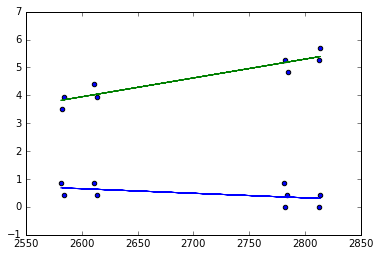

In [13]:
plt.scatter(x, y)
for n in range(len(tracks_params)):
    plt.plot(x, tracks_params[n][0] * x + tracks_params[n][1])
plt.show()

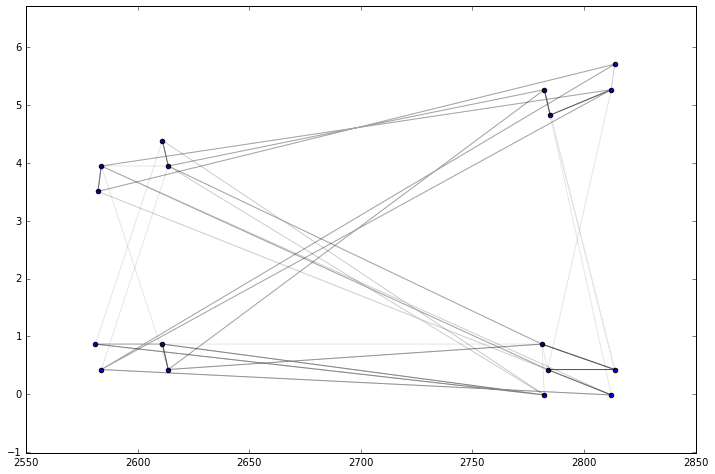

In [14]:
plt.figure(figsize=(12, 8))
plt.scatter(x, y)

for track in track_inds:
    
    plt.plot(x[track], y[track], alpha=0.1, color='0')
    pass

plt.ylim(y.min()-1, y.max()+1)
plt.show()

# Train Classifier for the Tracks Combination

In [15]:
from baseline import SimpleTemplateMatching
from hough import LinearHoughModel
from reconstruction import TracksReconstruction2D
from combination import Combinator, SuperCombinator
from retina import Retina2DTrackerTwo
from sklearn.linear_model import RANSACRegressor
from ransac import RANSACTracker


from metrics import TracksReconstractionMetrics, CombinatorQuality

### Tracks Reconstruction

In [16]:
%%time
from multiprocessing import Pool
from utils import merge_dicts

event_ids = event_ids_test
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    # Select model for the tracks reconstruction
    #stm_y = LinearHoughModel(k_params=(-0.35, 0.35, 2500), b_params=(-850, 850, 2500), n_candidates=2, show=False)
    #stm_stereo = LinearHoughModel(k_params=(-0.3, 0.3, 100), b_params=(-500, 500, 100), n_candidates=1, show=False)
    #stm_y = FastHough(n_tracks=2, min_hits=3, k_size=0.7/4000, b_size=1700./4000, k_limits=(-0.35, 0.35), b_limits=(-850, 850))
    #stm_stereo = FastHough(n_tracks=1, min_hits=3, k_size=0.6/160, b_size=1000./160, k_limits=(-0.3, 0.3), b_limits=(-500, 500))
    
    clustering=Clusterer(x_depth=2, y_depth=4, n_min=2)
    stm_y = FastHough(n_tracks=2, min_hits=3, k_size=0.7/4000, b_size=1700./4000, 
                      k_limits=(-0.35, 0.35), b_limits=(-850, 850), clustering=clustering)
    stm_stereo = FastHough(n_tracks=1, min_hits=3, k_size=0.6/160, b_size=1000./160, 
                           k_limits=(-0.3, 0.3), b_limits=(-500, 500), clustering=clustering)
    
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    return one_track

if __name__ == "__main__":
    p = Pool(3)
    results = p.map(tracks_reconstruction, event_ids)
    tracks = merge_dicts(results)

CPU times: user 20.4 ms, sys: 11.3 ms, total: 31.6 ms
Wall time: 3.24 s


In [17]:
%%time

tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

for event_id in tracks.keys():
    
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    labels12 = tracks[event_id]['labels12']
    tracks_params12 = tracks[event_id]['params12']
    labels34 = tracks[event_id]['labels34']
    tracks_params34 = tracks[event_id]['params34']
    
    # Select model for the tracks reconstruction
    # stm_y = LinearHoughModel(k_params=(-0.2, 0.2, 0.0004), b_params=(-800, 800, 1.6), min_hits=4, multiplier=2)
    # stm_stereo = LinearHoughModel(k_params=(-0.2, 0.2, 0.005), b_params=(-800, 800, 10), min_hits=4, multiplier=2)
    
    
    # Tracks reconstruction before the magnet
    # tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d12.fit(event12, weights12)
    
    # labels12 = tr2d12.labels_
    # tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2, n_tracks=2)
    trm12.fit(labels12, event12)

    tracks_metrics_before_y.loc[len(tracks_metrics_before_y)] = [event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]

    tracks_metrics_before_stereo.loc[len(tracks_metrics_before_stereo)] = [event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    # tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d34.fit(event34, weights34)
    
    # labels34 = tr2d34.labels_
    # tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2, n_tracks=2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_y.loc[len(tracks_metrics_after_y)] = [event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]

    tracks_metrics_after_stereo.loc[len(tracks_metrics_after_stereo)] = [event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
        
    
    # Combination of the tracks before and after the magnet
    #comb = SuperCombinator(classifier=folding.estimators[0])
    comb = Combinator()
    #comb = SuperCombinator(classifier=xgb_base)
    #comb = SuperCombinator(classifier=folding.estimators[0])
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_true)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]

    
    
    # Overall quality
    line = numpy.array([1, 
                         (trm12.recognition_efficiency_y_ == 1)*1, 
                         (trm12.recognition_efficiency_stereo_ >= 1)*1, 
                         (trm12.recognition_efficiency_ == 1)*1,
                         (trm34.recognition_efficiency_y_ == 1)*1, 
                         (trm34.recognition_efficiency_stereo_ >= 1)*1, 
                         (trm34.recognition_efficiency_ == 1)*1, 
                         (cq.n_combined_ >= 2)*1,
                         (cq.reco_eff_ == 1)*1]).cumprod()
    pass_stages.loc[len(pass_stages)] = numpy.concatenate(([event_id], line), axis=0)


CPU times: user 17.4 s, sys: 189 ms, total: 17.6 s
Wall time: 17.6 s


# Quality

# Stations 1&2

### Y-views

In [18]:
tracks_metrics_before_y.mean(axis=0)

EventID      2567.573684
AvgEff          0.992091
RecoEff         0.997368
GhostRate       0.000000
CloneRate       0.000877
dtype: float64

### Stereo-views

In [19]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      2567.573684
AvgEff          0.989423
RecoEff         0.997368
GhostRate       0.000000
CloneRate       0.000000
dtype: float64

### Stations 1&2

In [20]:
tracks_metrics_before_all.mean(axis=0)

EventID      2567.573684
AvgEff          0.990209
RecoEff         0.998246
GhostRate       0.000000
CloneRate       0.000000
dtype: float64

### Track efficiency

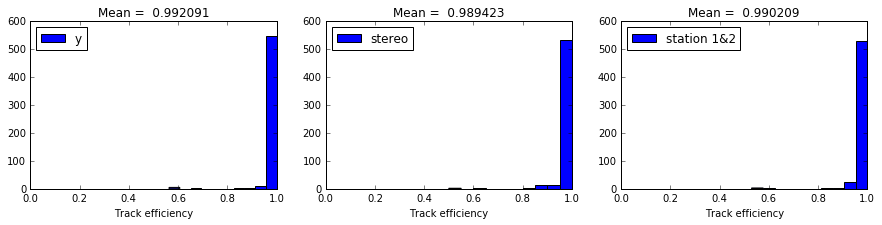

In [21]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

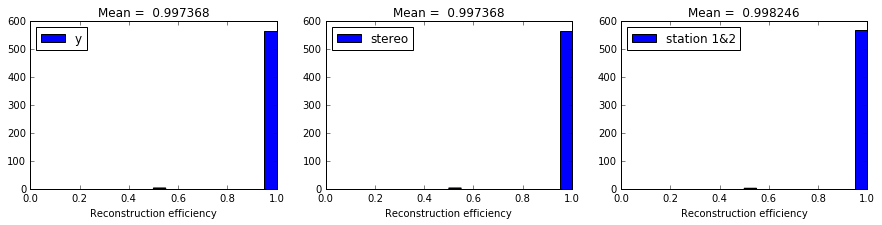

In [22]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [23]:
tracks_metrics_after_y.mean(axis=0)

EventID      2567.573684
AvgEff          0.994221
RecoEff         0.992982
GhostRate       0.000877
CloneRate       0.000877
dtype: float64

### Stereo-views

In [24]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      2567.573684
AvgEff          0.992236
RecoEff         0.993860
GhostRate       0.000000
CloneRate       0.000000
dtype: float64

### Station 3&4

In [25]:
tracks_metrics_after_all.mean(axis=0)

EventID      2567.573684
AvgEff          0.993017
RecoEff         0.993860
GhostRate       0.000877
CloneRate       0.000000
dtype: float64

### Tracks efficiency

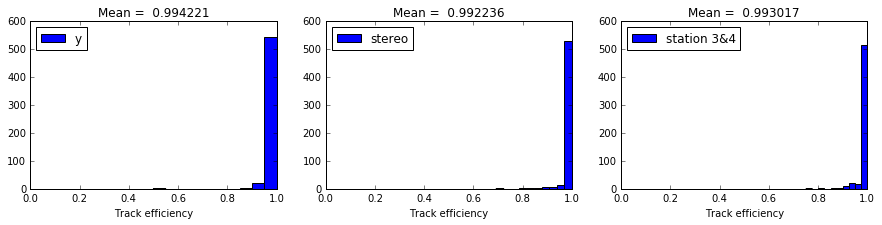

In [26]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

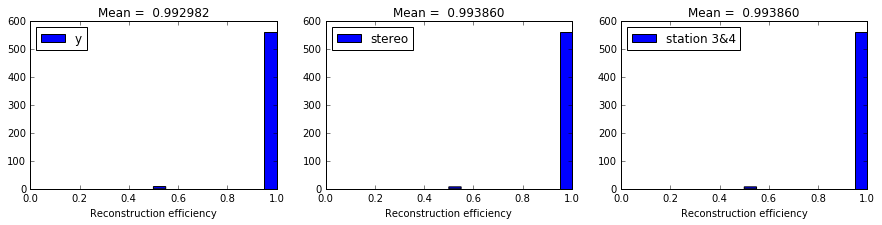

In [27]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [28]:
combinations_quality.mean(axis=0)

EventID      2567.573684
RecoEff         0.980702
GhostRate       0.001754
CloneRate       0.000000
NCombined       1.961404
dtype: float64

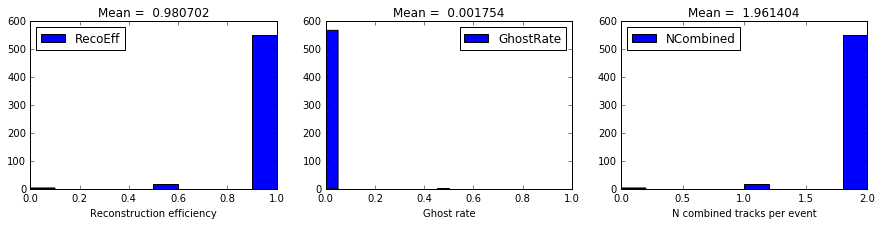

In [29]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

96.6666666667


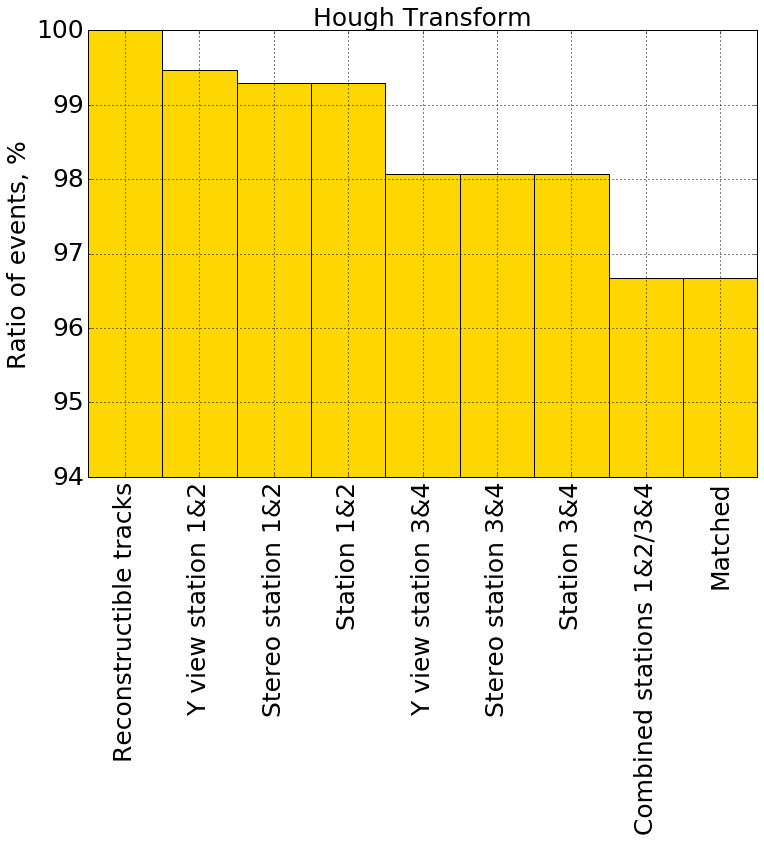

In [30]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages[pass_stages.columns[1:]].sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(12,8))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(-0.5, 8.5)
plt.ylim(94, 100)
#plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=25)
plt.grid(linewidth=1)
plt.title('Hough Transform', size=25)
plt.show()

In [31]:
bar_values

array([ 100.        ,   99.47368421,   99.29824561,   99.29824561,
         98.07017544,   98.07017544,   98.07017544,   96.66666667,
         96.66666667])

In [32]:
#event_ids = numpy.unique(data.EventID.values)

def TotalEffVsTrackEff(event_ids, track_eff_cuts):

    total_efficiencies = []
    momentum_mae = []

    for cut in track_eff_cuts:

        combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                         'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

        pass_stages = pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                                'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

        for event_id in event_ids:

            # Get an event
            event = data[data.EventID == event_id]
            event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
            event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]


            labels12 = tracks[event_id]['labels12']
            tracks_params12 = tracks[event_id]['params12']
            labels34 = tracks[event_id]['labels34']
            tracks_params34 = tracks[event_id]['params34']

            # Quality metrics of the reconstruction
            trm12 = TracksReconstractionMetrics(cut, n_tracks=2)
            trm12.fit(labels12, event12)

            # Quality metrics of the reconstruction
            trm34 = TracksReconstractionMetrics(cut, n_tracks=2)
            trm34.fit(labels34, event34)

            # Combination of the tracks before and after the magnet
            #comb = SuperCombinator(classifier=folding.estimators[0])
            comb = Combinator()
            comb.combine(tracks_params12, tracks_params34)


            # Quality of the combination
            cq = CombinatorQuality()
            cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)



            # Overall quality
            line = numpy.array([1, 
                                 (trm12.recognition_efficiency_y_ == 1)*1, 
                                 (trm12.recognition_efficiency_stereo_ >= 1)*1, 
                                 (trm12.recognition_efficiency_ == 1)*1,
                                 (trm34.recognition_efficiency_y_ == 1)*1, 
                                 (trm34.recognition_efficiency_stereo_ >= 1)*1, 
                                 (trm34.recognition_efficiency_ == 1)*1, 
                                 (cq.n_combined_ >= 2)*1,
                                 (cq.reco_eff_ == 1)*1]).cumprod()
            pass_stages.loc[len(pass_stages)] = numpy.concatenate(([event_id], line), axis=0)

        bar_values = pass_stages[pass_stages.columns[1:]].sum(axis=0).values
        bar_values = bar_values / bar_values[0] * 100

        total_eff = bar_values[-1]
        total_efficiencies.append(total_eff)

    total_efficiencies = numpy.array(total_efficiencies)

    return total_efficiencies

In [33]:
%%time
track_eff_cuts = numpy.linspace(0, 1., 21)
total_efficiencies = TotalEffVsTrackEff(event_ids, track_eff_cuts)

CPU times: user 1min 34s, sys: 1.07 s, total: 1min 35s
Wall time: 1min 37s


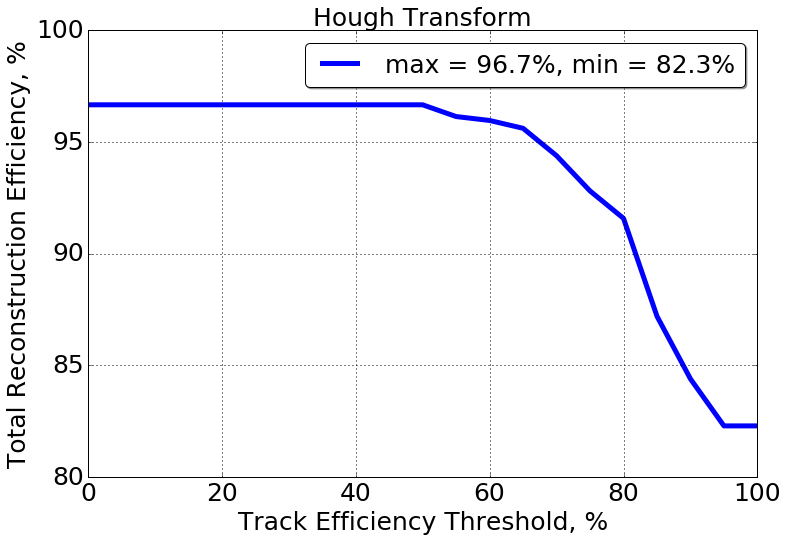

In [34]:
plt.figure(figsize=(12, 8))
l = 'max = ' + str(numpy.round(total_efficiencies[0], 1)) + '%, ' + 'min = ' + str(numpy.round(total_efficiencies[-1], 1)) + '%'
plt.plot(track_eff_cuts*100, total_efficiencies, linewidth=5, label=l)
plt.legend(loc="best", prop={'size':25},  shadow=True, fancybox=True)
plt.title("Hough Transform", fontsize=25)
plt.xlabel('Track Efficiency Threshold, %', fontsize=25)
plt.ylabel('Total Reconstruction Efficiency, %', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(80, 100)
plt.xlim(0., 100.)
plt.grid(linewidth=1)
plt.show()

# Momentum

In [35]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

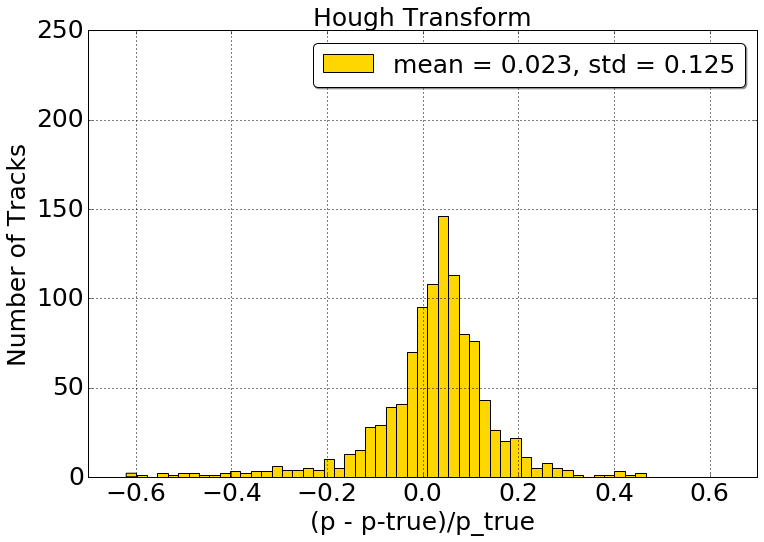

In [36]:
plt.figure(figsize=(12, 8))
q = -p_err[numpy.isfinite(p_err)*(numpy.abs(p_err)<=0.7)]
l = 'mean = ' + str(numpy.round(q.mean(), 3)) + ', std = ' + str(numpy.round(q.std(), 3))
plt.hist(q, bins=50, normed=False, label=l, color='gold')
#plt.hist(p_err[numpy.isfinite(p_err)], bins=50)

plt.title('Hough Transform', size=25)
plt.legend(loc="best", prop={'size':25},  shadow=True, fancybox=True)
#plt.title("TrackEff vs RecoEff", fontsize=25)
plt.xlabel('(p - p-true)/p_true', fontsize=25)
plt.ylabel('Number of Tracks', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0, 250)
plt.xlim(-0.7, 0.7)
plt.grid(linewidth=1)
plt.show()

In [37]:
len(p_err) - len(p_err[numpy.isfinite(p_err)])

2

In [38]:
print numpy.abs(p_err[numpy.isfinite(p_err)]).mean() * 100

10.1281812445


# Did not recognized tracks

In [39]:
pass_stages[pass_stages.Matching.values == 0]

,EventID,RecoEvents,Y12,Stereo12,Stations12,Y34,Stereo34,Stations34,Combination,Matching
35,1848,1,1,1,1,1,1,1,0,0
49,3165,1,1,1,1,1,1,1,0,0
81,143,1,1,1,1,0,0,0,0,0
146,4342,1,1,1,1,1,1,1,0,0
160,270,1,1,1,1,0,0,0,0,0
227,3781,1,1,1,1,0,0,0,0,0
230,4490,1,1,1,1,0,0,0,0,0
277,4580,1,1,0,0,0,0,0,0,0
281,3085,1,0,0,0,0,0,0,0,0
320,2605,1,1,1,1,1,1,1,0,0


In [40]:
bad_events = pass_stages[pass_stages.Matching.values == 0]['EventID'].values

1848.0


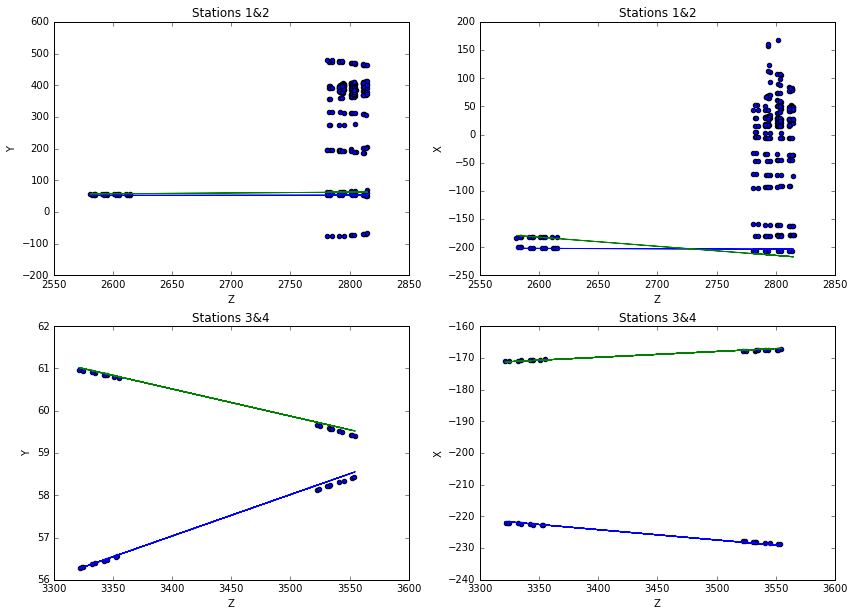

3165.0


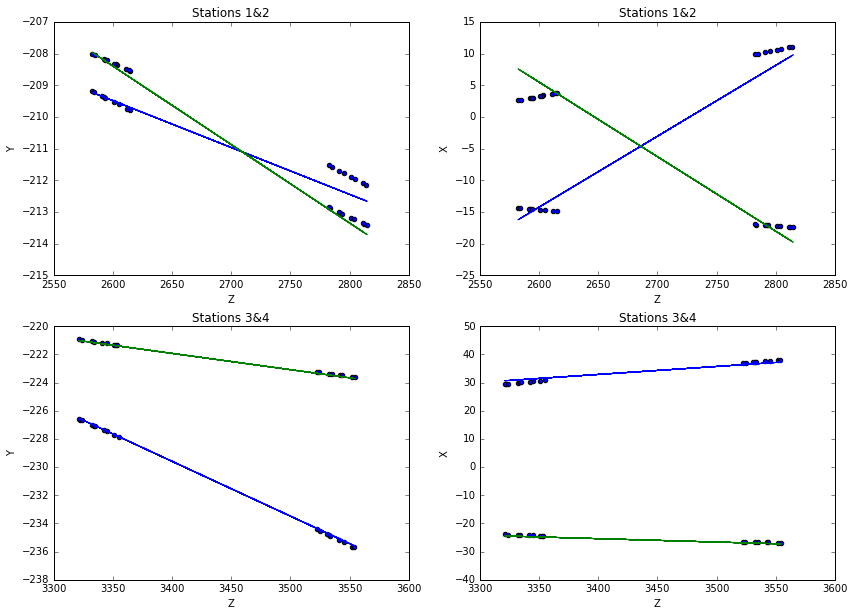

143.0


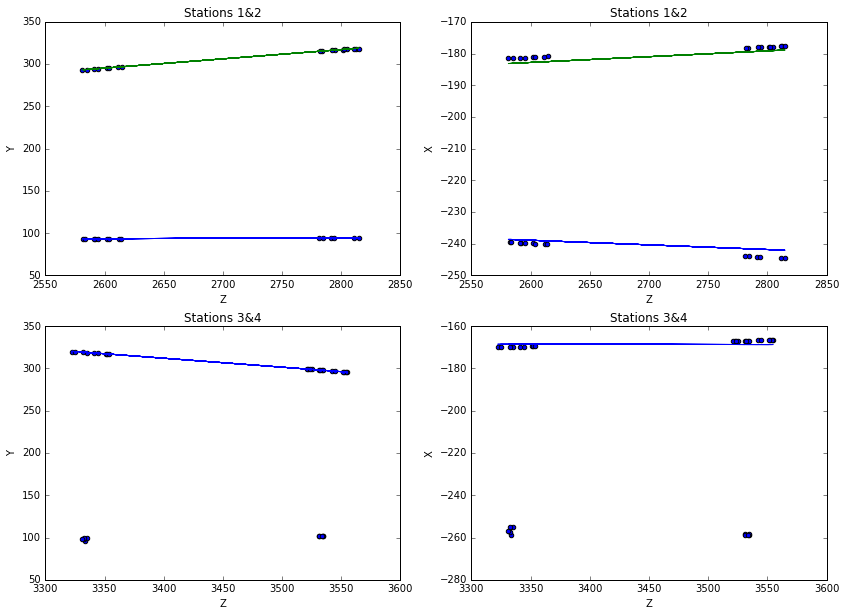

4342.0


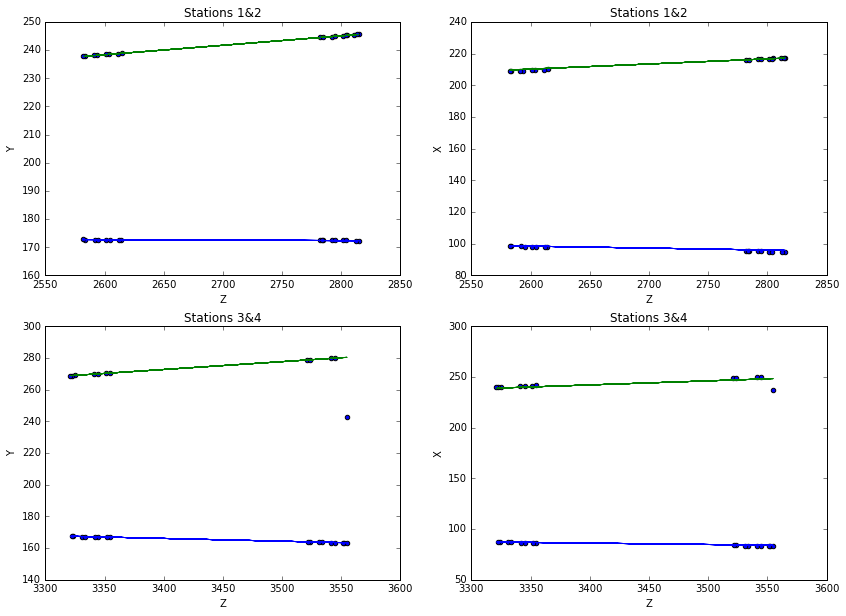

270.0


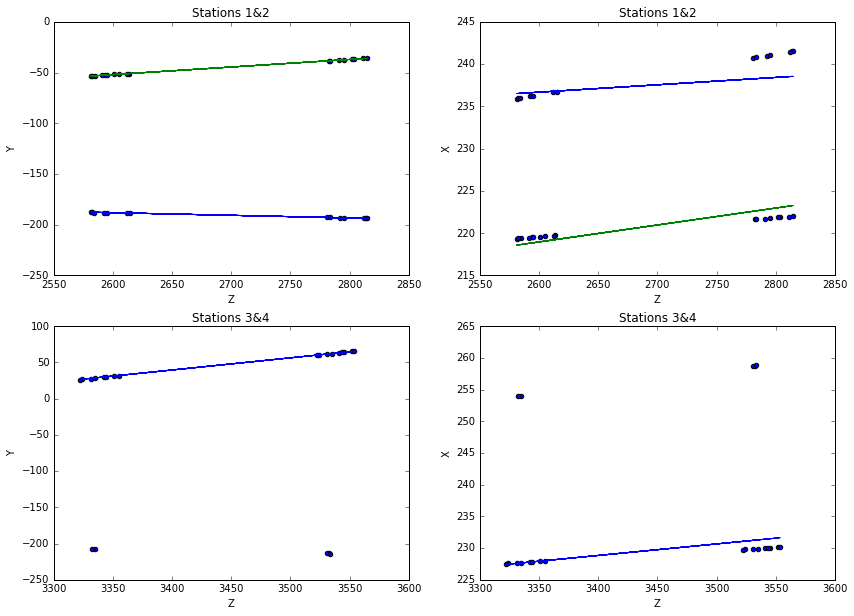

3781.0


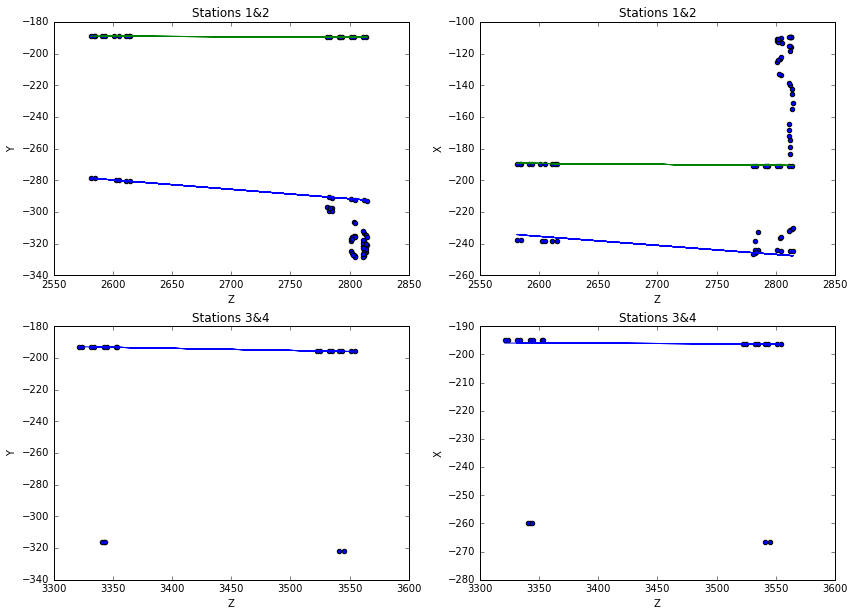

4490.0


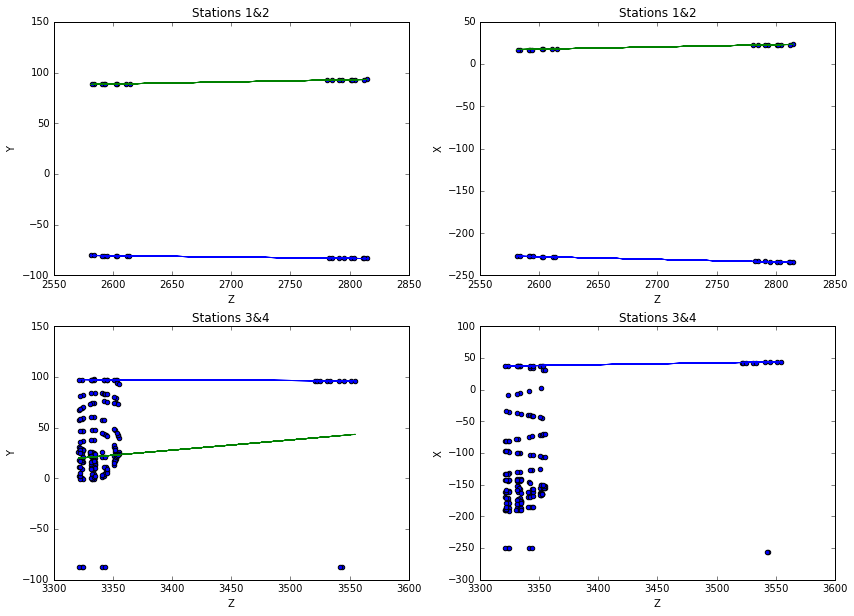

4580.0


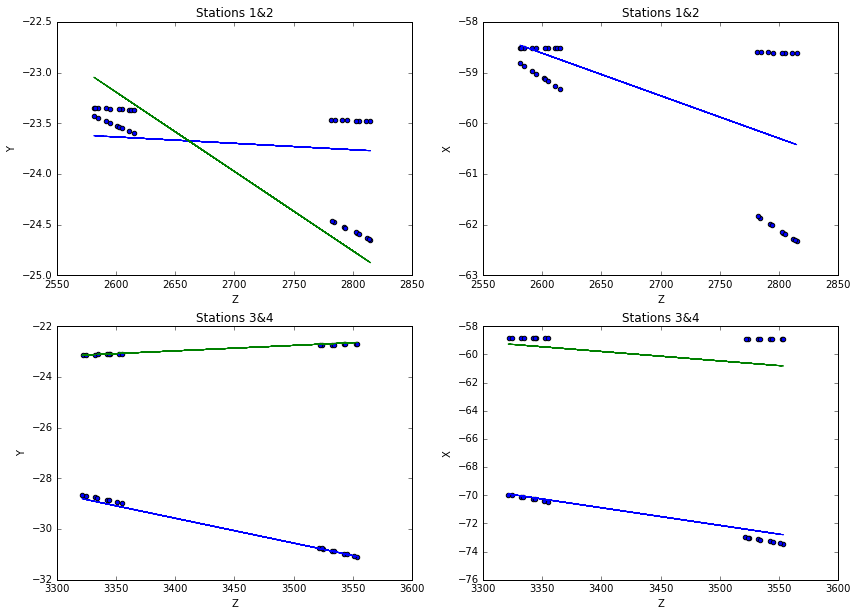

3085.0


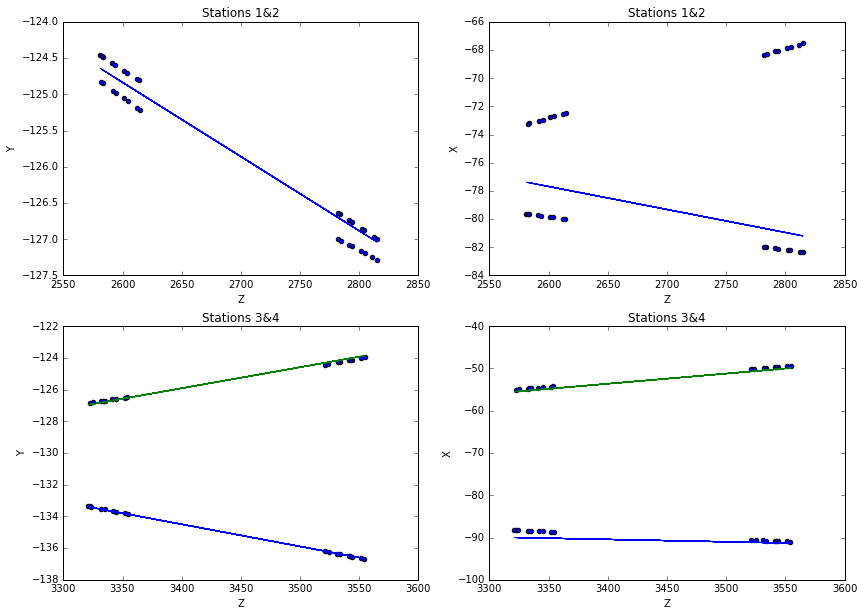

2605.0


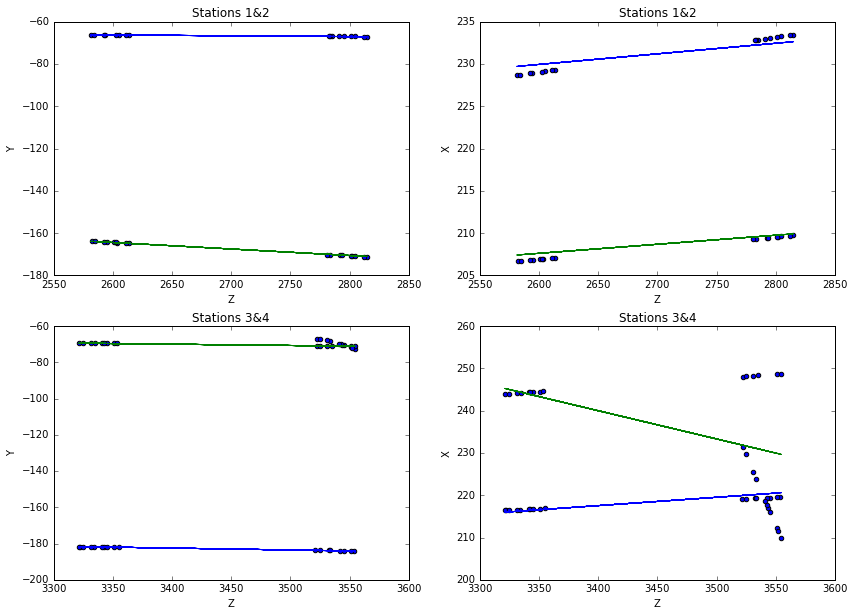

2685.0


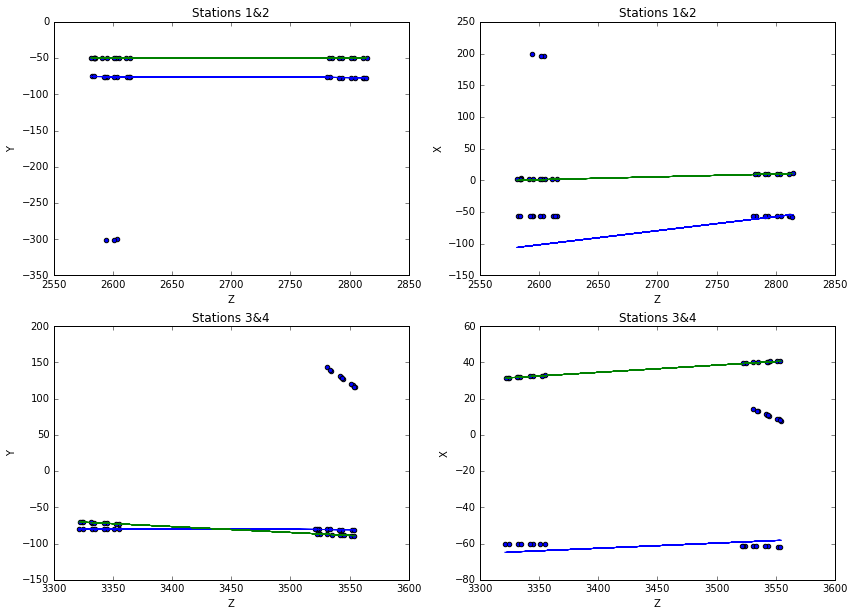

1722.0


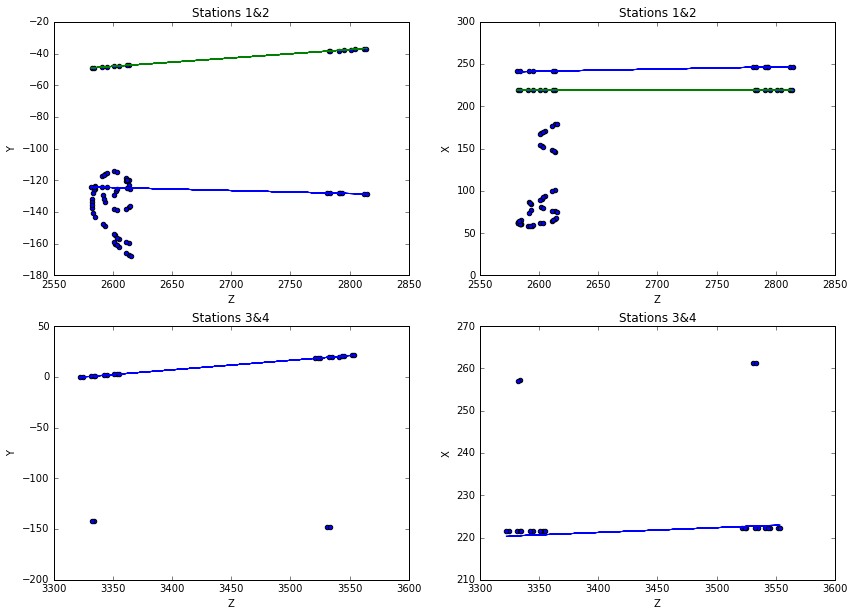

2762.0


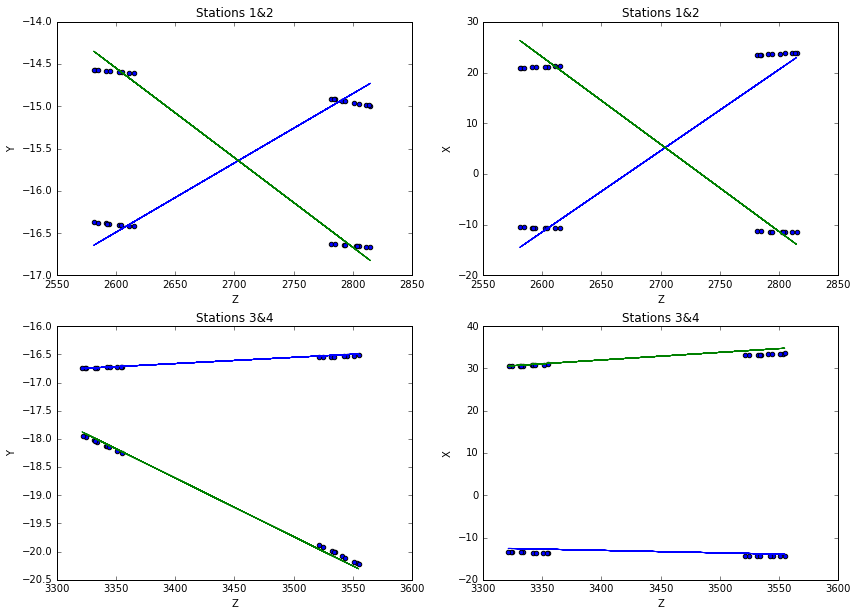

1756.0


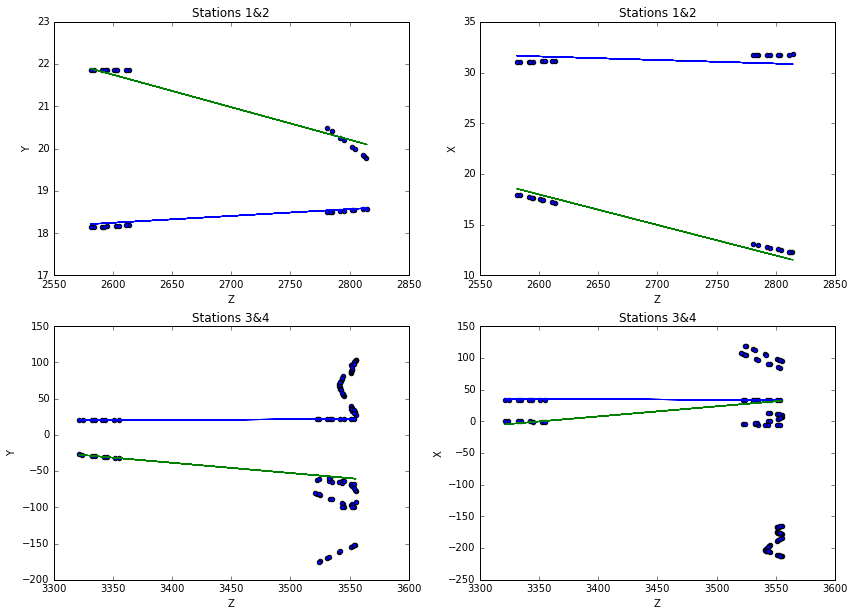

1769.0


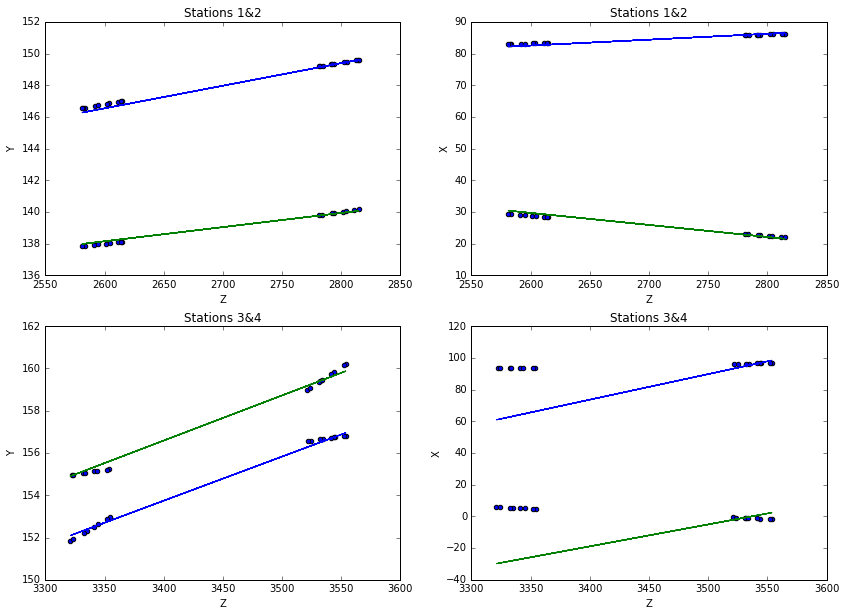

916.0


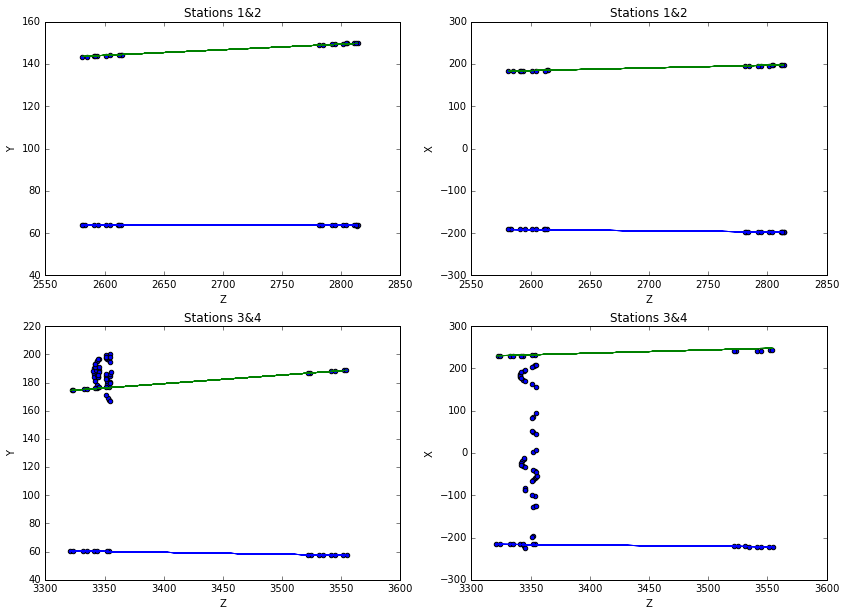

3916.0


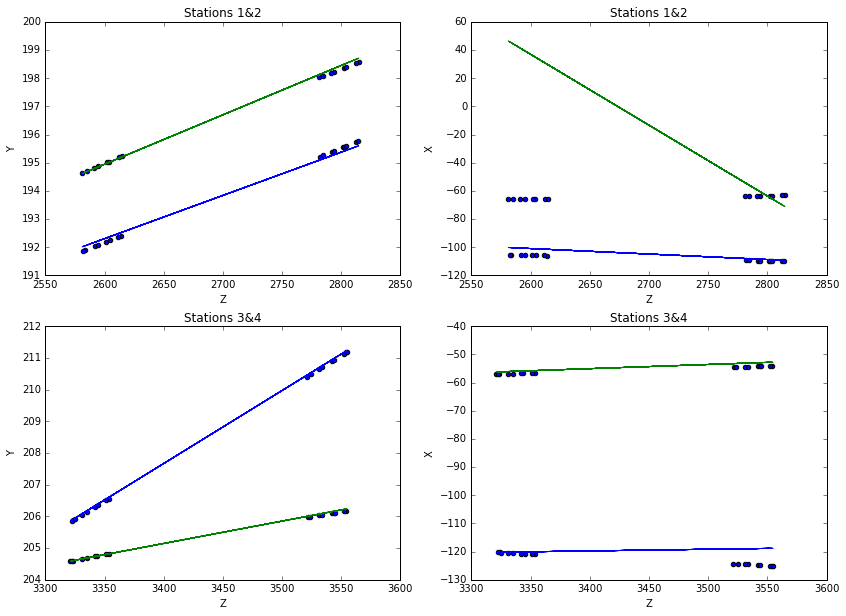

1528.0


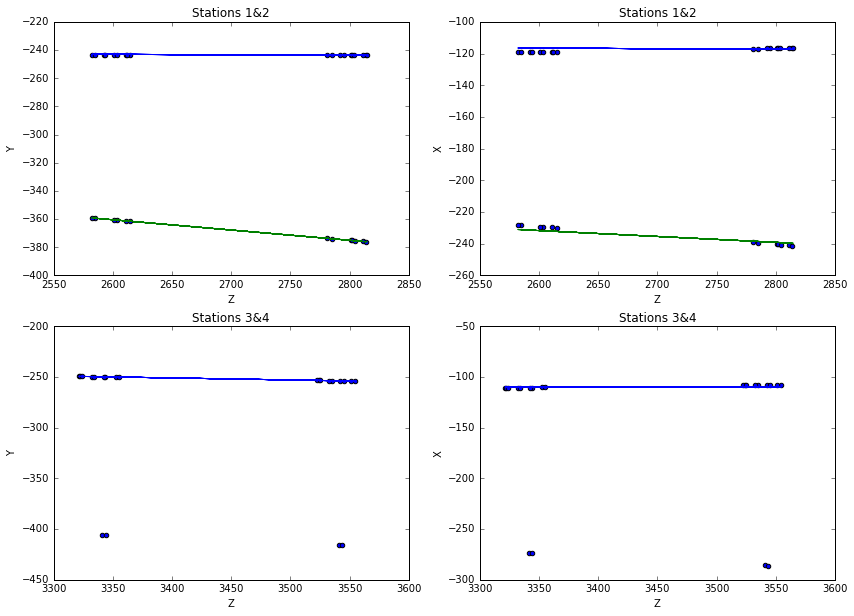

2040.0


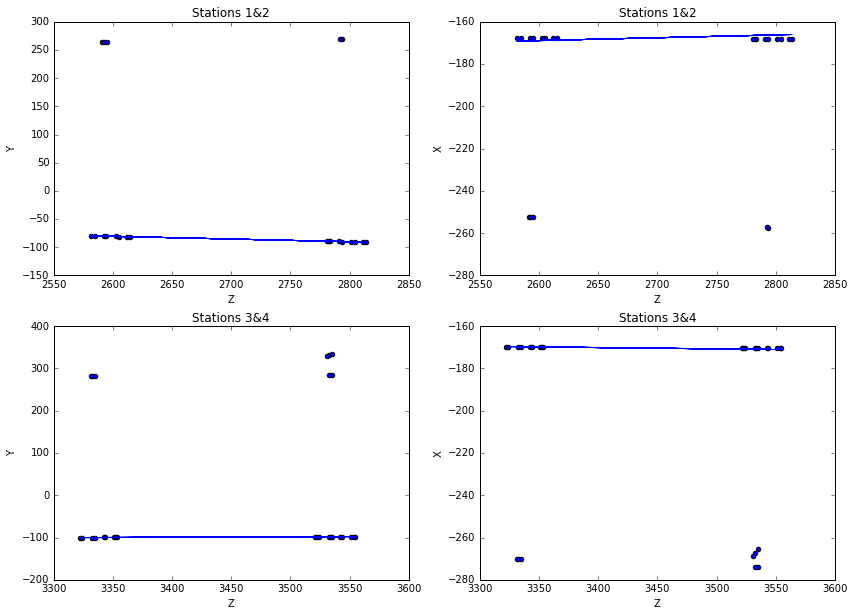

In [41]:
from utils import plot_event

for event_id in bad_events:
    print event_id
    plot_event(event_id, data, tracks)